In [16]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.models.train_model import *
from src.visualization.vis_data import *
from src.features.landuse import *
from src.data.fire_data import cal_repeat_spots_ex_year, cal_repeat_spots


import seaborn as sns
output_notebook()
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [2]:
# start building dataset from scratch only perform this when new data files are added 
dataset = Dataset('Hanoi')
dataset.build_all_data(build_fire=True, build_holiday=True)

add Berkerley stations ['Ha_Dong']
add US embassy data
Averaging data from 3 stations


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Loading all hotspots data. This might take sometimes


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:53<00:00,  1.78s/it]


before drop (3658463, 20)
after drop (3606529, 12)


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:34<00:00,  1.13s/it]


before drop (3658463, 20)
after drop (3606529, 12)
Getting holiday for  vietnam


In [3]:
dataset = Dataset('Hanoi')
dataset.load_()

# Pollution

pollutants to plot Index(['PM2.5'], dtype='object')


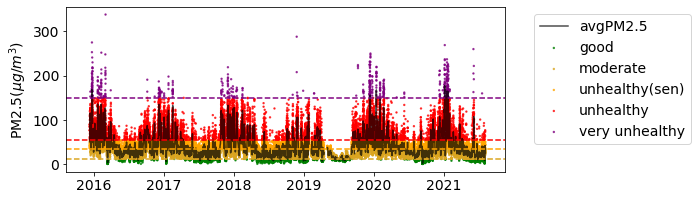

In [4]:
# plot the raw data
plot_all_pollutions(dataset.poll_df, city_name=dataset.city_name)

PM2.5    216.166667
dtype: float64


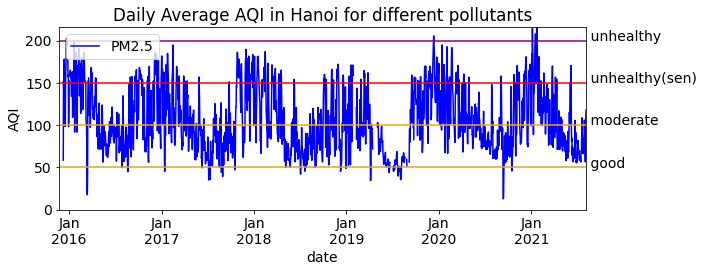

In [5]:
plot_polls_aqi(dataset.poll_df.copy(), dataset.roll_dict, dataset.city_name, filename=dataset.report_folder + 'all_pol_aqi.png' )

ValueError: too many values to unpack (expected 2)

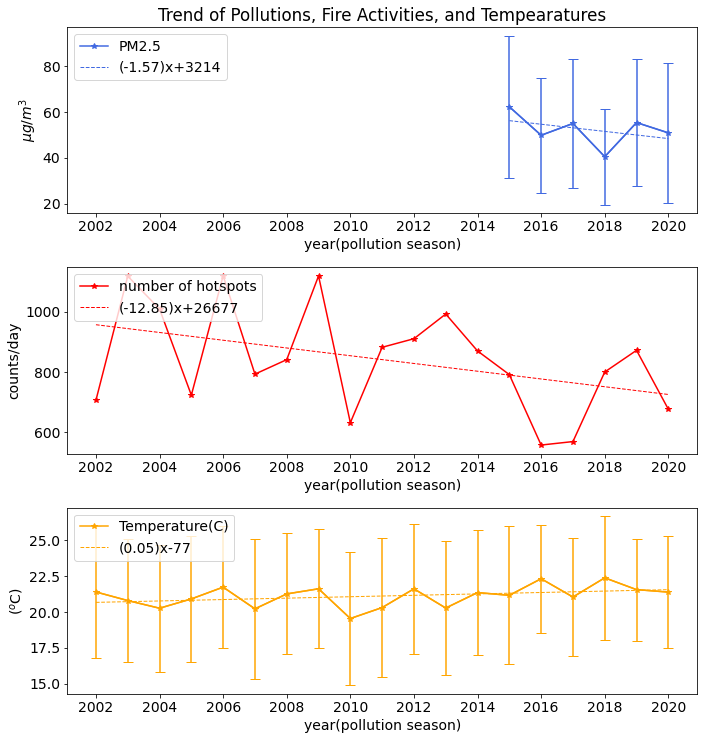

In [6]:
ax, year_avg = plot_yearly_ln(dataset, filename=dataset.report_folder + 'compare_ln_trends.png')

In [ ]:
plot_season_aqi(dataset.poll_df.copy(), dataset.roll_dict, 'PM2.5', filename=dataset.report_folder + 'seasonal_pattern_PM25.png')

In [ ]:
compare_seson_avg(dataset, agg='mean', filename=dataset.report_folder + 'fire_PM25_season.png')

In [ ]:
_, ax = plt.subplots(2, 1, figsize=(9, 7), sharex=True)
plot_hour_avg(dataset.poll_df.copy(), 'PM2.5', ax[0],  color='blue')
 
df = df.groupby('time_of_day').mean().rolling(2, min_periods=0,center=True).mean()
ax[1].plot(df['Wind_Speed(kmph)'], color='green', label='Wind_Speed(kmph)')
ax[1].set_ylabel('Wind_Speed(kmph)')
ax[1].set_xlabel('hour')
ax[1].legend(loc='upper left')
plt.tight_layout()

# Chemical Fingerprint

In [40]:
# load daily average pollution data
aqcn = pd.read_csv(glob('../data/aqcn_data/hanoi*.txt')[0],na_values=' ')
aqcn.columns = ['datetime','PM2.5','PM10', 'O3', 'NO2', 'SO2', 'CO']
aqcn['datetime'] = pd.to_datetime(aqcn['datetime'])

In [56]:
# extract all data from Vietnamese EPA 
dfs = glob('../data/vn_epa/*.csv')
hanoi_df = []
for df in dfs:
    df = pd.read_csv(df, na_values='-')
    # keep only hanoi data
    df = df[df['city'] == 'Hanoi']
    df['datetime'] = pd.to_datetime(df['datetime'])
    hanoi_df.append(df)
    
hanoi_df = pd.concat(hanoi_df, ignore_index=True)
# drop duplicates data
hanoi_df = hanoi_df.drop_duplicates()
hanoi_df = hanoi_df.drop(['VN_AQI', 'city','station'], axis=1)
hanoi_df = hanoi_df.sort_values('datetime')
# taking average of all the station in hanoi
hanoi_df = hanoi_df.groupby('datetime', as_index=False).mean().round()

In [57]:
hanoi_df = pd.concat([hanoi_df, aqcn]).drop_duplicates('datetime').sort_values('datetime')

In [58]:
hanoi_df = hanoi_df.set_index('datetime')

In [60]:
# calculate the average 
sum_df = hanoi_df.mean()

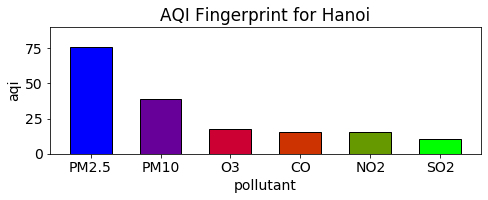

In [63]:
plot_chem_print(sum_df, dataset.city_name, filename=dataset.report_folder + 'fingerprint.png')

# Fire Zone 

Fire map and power plants from https://endcoal.org/tracker/

In [3]:
dataset.city_info

x = merc_x(dataset.city_info['Longitude'])
y = merc_y(dataset.city_info['Latitude'])
#stepx = 2E5

stepx = 1E6
stepy = stepx

In [146]:
# select fire data 
fire = dataset.fire
i = 0
month_list = ['2019-03','2019-04']
month = month_list[i]
color = 'red'
fire1 = fire.loc[month:month_list[i+1]]

month_list = ['2018-12','2019-01']
month = month_list[i]
fire2 = fire.loc[month:month_list[i+1]]

In [11]:
# range bounds supplied in web mercator coordinates
p = figure(x_range=(x-1*stepx,x+1*stepx), y_range=(y-stepy*0.3, y+stepy*0.0001),
           x_axis_type="mercator", y_axis_type="mercator",
          title = dataset.city_name)
p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))

# add city center
p.scatter(x,y,color='red',line_color='black',size=10, legend_label=dataset.city_name)

# plot hotspots at the begining and end of winter season

#p.scatter(fire1['long_km']*1000,fire1['lat_km']*1000,color='red',size=1, alpha=0.5,legend_label='fire in Mar 2019')

#p.scatter(fire2['long_km']*1000,fire2['lat_km']*1000,color='blue',size=1, alpha=0.5, legend_label='fire in Dec 2018')

#add circles
labels = ['0-120km','120-400km','400-700km','700-1200km']

rs = [120, 400, 700, 1200]
rs.reverse()
labels.reverse()
colors = get_color(color_length=len(labels),cmap=cm.jet)
for i, (r, label, color) in enumerate(zip(rs, labels, colors)):
    if i ==3 or i ==2:
        alpha=0.4
    else:
        alpha=0.2
        
    xy = get_circle(x,y,r=r*1E3)
    p.patch(xy[0,:],xy[1,:],alpha=alpha,line_width=2,line_color='black',color=color, legend_label=label)
    
p.legend.location = "bottom_right"

show(p)
export_png(p, filename=dataset.report_folder + "fire_zone.png")

'C:\\Users\\Benny\\Documents\\Fern\\aqi_thailand2\\reports\\hanoi\\fire_zone.png'

In [123]:
# list of power plants hear Hanoi
plants = [[20.4809977, 106.5604517, 'coal']]

# Analyze Fire Activities

## Landuse

In [ ]:
dataset = Dataset('Hanoi')
label_landuse_fire('../data/hanoi/' + 'fire_m.csv')
fire = pd.read_csv('../data/hanoi/fire_m_label.csv')
fire = add_countries(fire, city_xy_m=[dataset.city_info['long_m'], dataset.city_info['lat_m']], filename='../data/jakarta/fire_m_label.csv')

In [6]:
dataset = Dataset('Hanoi')
dataset.load_()

# label location of the fire using landuse data around chiang mai
# this command generate another file named '../data/chiang_mai/' + 'fire_m_label.csv' 
# I don't wanna save over the old file to prevent accidently save over the labeling information 
fire = pd.read_csv('../data/bangkok/' + 'fire_m_label.csv')
fire['datetime'] = pd.to_datetime(fire['datetime'])
# add season information because I would like to consider the fire in pollution season only
fire = add_season(fire.set_index('datetime'), start_month='-11-01', end_month='-03-31')
fire = fire[fire['season'] != 'other']
fire['count'] = 1

In [8]:
zone_list = dataset.zone_list[:4]
zone_list

[0, 120, 400, 700]

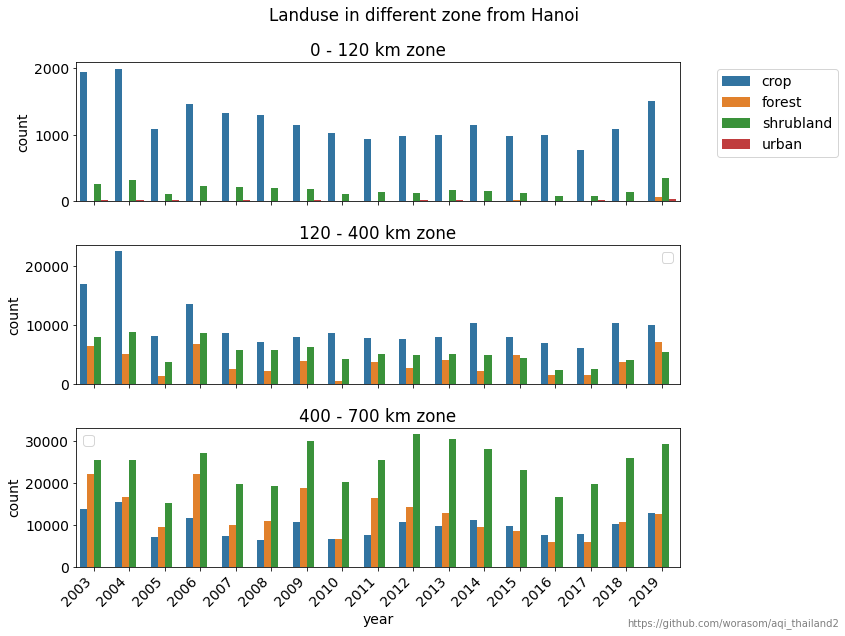

In [12]:
zone_list = dataset.zone_list[:4]
prop_type = 'label'

fig, ax = plt.subplots(len(zone_list[:-1]),1, figsize=(12, 3*len(zone_list[:-1])), sharex=True)


for i, (a, min_d, max_d) in enumerate(zip(ax, zone_list, zone_list[1:])):
    temp = fire[(fire['distance']< max_d) & (fire['distance'] >= min_d)]
    temp = temp.groupby(['year', prop_type], as_index=False)['count'].count()
    temp = temp[~temp[prop_type].isin(['water', 'unclassified'])]
    temp = temp[temp['year'] !=2002]
    
    sns.barplot(x="year", y="count", hue=prop_type, data=temp, ax=a)
    a.set_title(f'{min_d} - {max_d} km zone')
    if i==0:
        a.legend(bbox_to_anchor=(1.05, 1))
    else:
        a.legend([])
        
    a.set_xlabel('')

a.set_xlabel('year')
a.set_xticklabels(a.get_xticklabels(), rotation=45, ha='right');
# add super title
fig.suptitle(f'Landuse in different zone from {dataset.city_name}')

plt.tight_layout()
wmark_plt(fig)

plt.savefig(dataset.report_folder + 'landuse_firezone.png')

## Repeating Pattern

In [13]:
# select fire in 600 km zone
max_distance = 700
subfire = fire[fire['distance'] <=max_distance]

In [16]:
subfire['count'] = 1
fire_no_nan = subfire[~subfire['country'].isna()]
country_list = fire_no_nan['country'].unique() 
country_list.sort()
# repeating hotspots  between year
repeat_out_year = []
repeat_list = [2, 4, 6, 8]
for country in country_list:
    s = cal_repeat_spots_ex_year(fire_no_nan[fire_no_nan['country']==country], repeat_list=repeat_list,accum=False)
    s.name = country 
    repeat_out_year.append(s)
    
repeat_out_year  =  pd.concat(repeat_out_year,axis=1)

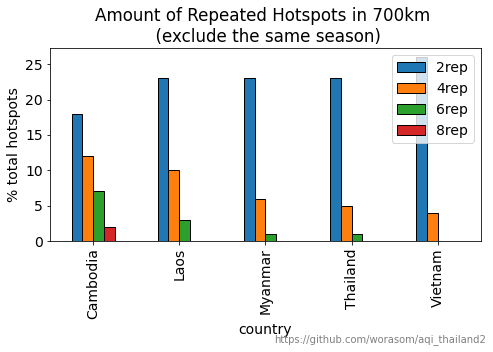

In [17]:
fig, ax = plt.subplots(1,1,figsize=(7,5))

color_list = get_color(color_length=len(country_list),cmap=cm.brg)

repeat_out_year.transpose().plot.bar(ax=ax, width=0.5, edgecolor='black',legend=None)


ti = f'Amount of Repeated Hotspots in {max_distance}km \n (exclude the same season)'

ax.set_title(ti)
ax.set_xlabel('country')
ax.set_ylabel('% total hotspots')

ax.legend(['2rep', '4rep','6rep','8rep'])
wmark_plt(fig)
    
plt.tight_layout()

plt.savefig(dataset.report_folder + 'fire_repeat_no_accum.png')

In [18]:
subfire['count'] = 1
fire_no_nan = subfire[~subfire['country'].isna()]
country_list = fire_no_nan['country'].unique() 
country_list.sort()
# repeating hotspots  between year
repeat_out_year_accum = []
repeat_list = [4]
for country in country_list:
    s = cal_repeat_spots_ex_year(fire_no_nan[fire_no_nan['country']==country], repeat_list=repeat_list,accum=True)
    s.name = country 
    repeat_out_year_accum.append(s)
    
repeat_out_year_accum =   pd.concat(repeat_out_year_accum,axis=1)

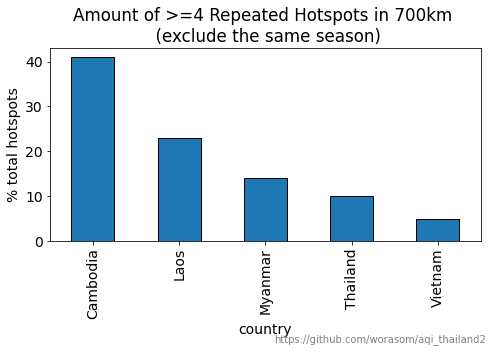

In [19]:
fig, ax = plt.subplots(1,1,figsize=(7,5))

color_list = get_color(color_length=len(country_list),cmap=cm.brg)

repeat_out_year_accum.transpose().plot.bar(ax=ax, width=0.5, edgecolor='black',legend=None)


ti = f'Amount of >=4 Repeated Hotspots in {max_distance}km \n (exclude the same season)'

ax.set_title(ti)
ax.set_xlabel('country')
ax.set_ylabel('% total hotspots')

wmark_plt(fig)
    
plt.tight_layout()
plt.savefig(dataset.report_folder + 'fire_repeat_accum.png')

# ML Model

In [174]:
dataset = Dataset('Hanoi')
dataset.load_()
dataset.feature_no_fire(fill_missing=True, cat_hour=True,group_hour=1)
fire_cols, *args = dataset.merge_fire()

data no fire has shape (35617, 37)
use default fire feature


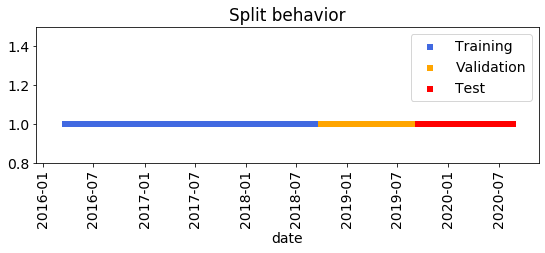

In [177]:
dataset.split_data(split_ratio=[0.6, 0.2, 0.2])
display_time_split(dataset.split_list)

In [180]:
model_meta = load_meta(dataset.model_folder + 'model_meta.json')

In [188]:
poll_meta = {'rolling_win': 1,
 'cat_hour': True,
 'fill_missing': True,
 'group_hour': 2}

In [192]:
model_meta['PM2.5'] = poll_meta

In [193]:
save_meta(dataset.model_folder + 'model_meta.json', model_meta)

## PM2.5

In [17]:
dataset = Dataset('Hanoi')

=================find the best RF model=================
best rf score  0.22233375834909572
val score after op_rf {'val_r2_score': 0.3477, 'val_r2': 0.5649, 'val_mean_squared_error': 1259.7636, 'val_mean_absolute_error': 25.6671, 'val_mean_absolute_percentage_error': 70.733, 'val_median_absolute_error': 15.0725}
test score after op_rf {'test_r2_score': 0.3097, 'test_r2': 0.5613, 'test_mean_squared_error': 578.2022, 'test_mean_absolute_error': 16.3186, 'test_mean_absolute_percentage_error': inf, 'test_median_absolute_error': 11.874}
================ remove unncessary columns no lag=================


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:58<00:00,  5.83s/it]


score after dropping columns  {'r2_score': 0.358, 'r2': 0.5651, 'mean_squared_error': 1239.804, 'mean_absolute_error': 25.6475, 'mean_absolute_percentage_error': 74.059, 'median_absolute_error': 15.6483}
export figure as  C:/Users/Benny/Documents/Fern/aqi_thailand2/reports/hanoi/_PM25_rf_fea_op2.png
================= find the best fire feature ===================
optimizing fire parameter using skopt optimizer. This will take about 20 mins
new fire parameter {'w_speed': 0.5, 'shift': -36, 'roll': 42, 'damp_surface': 4.9, 'wind_damp': 0, 'wind_lag': 1, 'split_direct': 0} give score = 1225.534561718195
op fire give val score {'val_r2_score': 0.3654, 'val_r2': 0.5798, 'val_mean_squared_error': 1225.5346, 'val_mean_absolute_error': 25.4536, 'val_mean_absolute_percentage_error': 73.1983, 'val_median_absolute_error': 15.5536}
op fire give test score {'test_r2_score': 0.3039, 'test_r2': 0.5606, 'test_mean_squared_error': 583.0416, 'test_mean_absolute_error': 16.7222, 'test_mean_absolute_perce

  0%|                                                                                          | 0/160 [00:00<?, ?it/s]

op4 test score {'test_r2_score': 0.4459, 'test_r2': 0.6788, 'test_mean_squared_error': 462.9028, 'test_mean_absolute_error': 13.8971, 'test_mean_absolute_percentage_error': inf, 'test_median_absolute_error': 9.5101}
================= remove unncessary lag columns =================


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [37:29<00:00, 14.06s/it]


score after dropping columns  {'r2_score': 0.4373, 'r2': 0.6696, 'mean_squared_error': 1086.7233, 'mean_absolute_error': 22.9636, 'mean_absolute_percentage_error': 58.6489, 'median_absolute_error': 12.2028}
best rf score  0.44883056541127075
val score after op6 {'val_r2_score': 0.4601, 'val_r2': 0.6605, 'val_mean_squared_error': 1042.7128, 'val_mean_absolute_error': 22.4788, 'val_mean_absolute_percentage_error': 59.6395, 'val_median_absolute_error': 11.9632}
test score after op6  {'testop6_r2_score': 0.4502, 'testop6_r2': 0.6756, 'testop6_mean_squared_error': 459.2755, 'testop6_mean_absolute_error': 13.9621, 'testop6_mean_absolute_percentage_error': inf, 'testop6_median_absolute_error': 9.6425}
final score for test set {'test_r2_score': 0.4702, 'test_r2': 0.6879, 'test_mean_squared_error': 442.592, 'test_mean_absolute_error': 13.7792, 'test_mean_absolute_percentage_error': inf, 'test_median_absolute_error': 9.5222}
daily avg score for test set {'avg_test_r2_score': 0.5982, 'avg_test_r2

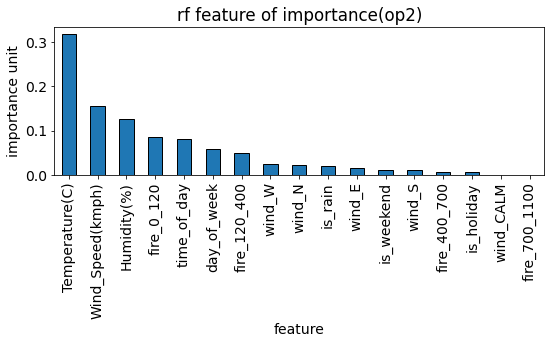

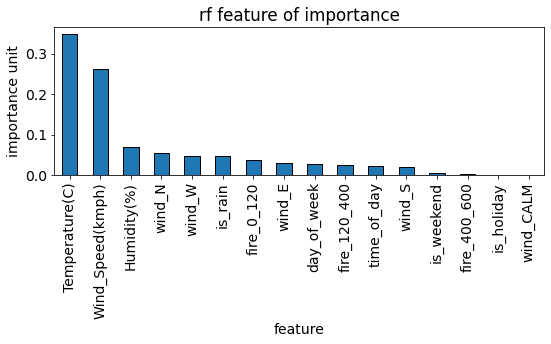

In [18]:
%%time
filename = dataset.model_folder + 'PM25_model_meta.json'
model_meta = load_meta(filename)
model_meta['rolling'] = 1
model_meta['cat_hour'] = 0
model_meta['cat_month'] = 0
model_meta['split_lists'] = [[0.55, 0.2, 0.25], [0.55, 0.2, 0.25], [0.75, 0.25]]
#model_meta['zone_list'] =  [0, 100, 200, 400, 600, 800, 1000]
save_meta(filename, model_meta)
# training 1 hour avg center
dataset, model, trainer = train_city_s1(city='Hanoi', pollutant= 'PM2.5', instr='MODIS', add_weight=True, op_fire_zone=True, op_lag=True, choose_cat_hour=True, choose_cat_month=False)

raw model performance {'test_r2_score': 0.4712, 'test_r2': 0.6886, 'test_mean_squared_error': 441.2349, 'test_mean_absolute_error': 13.7229, 'test_mean_absolute_percentage_error': inf, 'test_median_absolute_error': 9.52}
daily avg training error {'avg_trn_r2_score': 0.9, 'avg_trn_r2': 0.9549, 'avg_trn_mean_squared_error': 60.8178, 'avg_trn_mean_absolute_error': 5.8309, 'avg_trn_mean_absolute_percentage_error': 18.8879, 'avg_trn_median_absolute_error': 4.4267}
daily avg test error {'avg_test_r2_score': 0.5988, 'avg_test_r2': 0.7784, 'avg_test_mean_squared_error': 244.4085, 'avg_test_mean_absolute_error': 10.3206, 'avg_test_mean_absolute_percentage_error': 31.0199, 'avg_test_median_absolute_error': 7.2603}


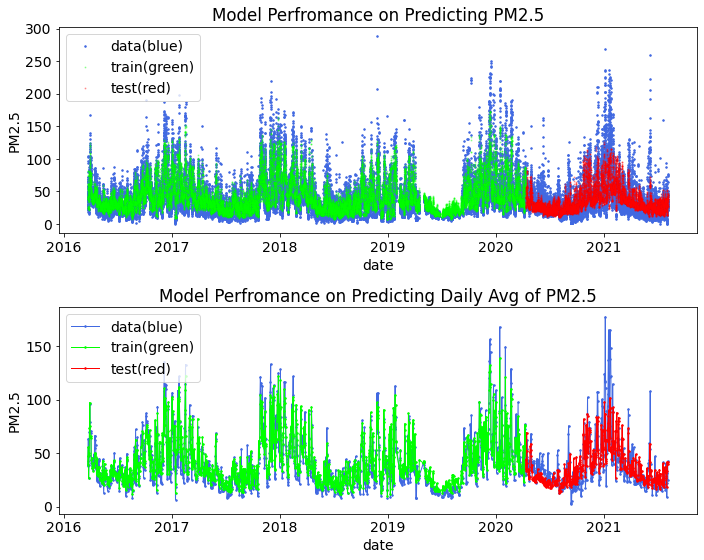

In [19]:
dataset, model, fire_cols, zone_list, feat_imp, rolling_win = load_model(city='Hanoi', pollutant='PM2.5' )
_, df = plot_model_perf(dataset=dataset, model= model, split_list=model_meta['split_lists'][-1], xlim=[], to_save=True)

Model performance vs seasonal pattern and residue

In [20]:
# calculate the average error for the test data
ytest_pred_df = cal_error(dataset, model, data_index=dataset.split_list[1])
ytest_pred_df_avg = ytest_pred_df.resample('d').mean().dropna()

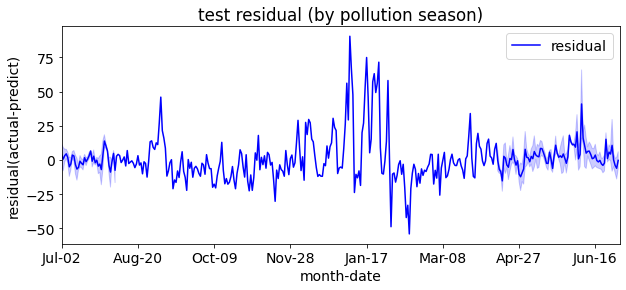

In [21]:
_, ax = plt.subplots(figsize=(10,4))
_ = plot_season_avg(ytest_pred_df, 'residual', ax, plot_error=True, roll=False, agg='mean')
ax.set_title('test residual (by pollution season)')
ax.set_ylabel('residual(actual-predict)')
plt.savefig(dataset.report_folder + 'PM25_season_residual.png', dpi=300 )

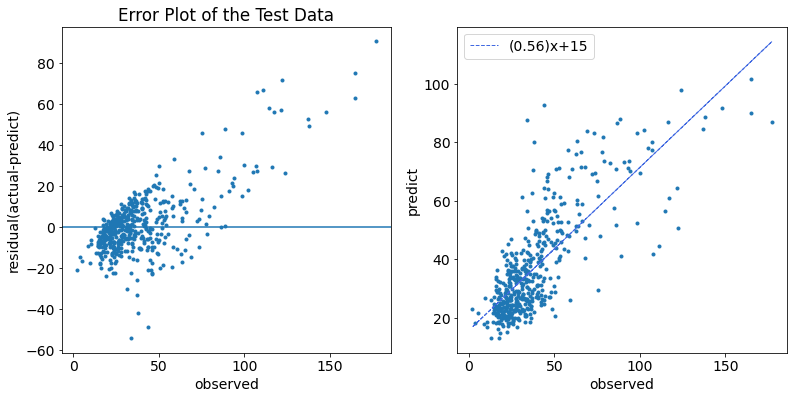

In [22]:
# plot residual vs actual value
_, ax = plt.subplots(1,2, figsize=(13, 6))

ax[0].scatter(ytest_pred_df_avg['actual'], ytest_pred_df_avg['residual'], marker='.')
ax[0].set_ylabel('residual(actual-predict)')
ax[0].set_xlabel('observed')
ax[0].axhline(0)
ax[0].set_title('Error Plot of the Test Data')

ax[1].scatter(ytest_pred_df_avg['actual'], ytest_pred_df_avg['pred'], marker='.')
ax[1].set_ylabel('predict')
ax[1].set_xlabel('observed')
#ax[1].set_title('Error Plot of the Test Data')
s = ytest_pred_df_avg['pred']
s.index = ytest_pred_df_avg['actual']
add_ln_trend_line(s, ax=ax[1])
ax[1].legend()
plt.savefig(dataset.report_folder + 'PM25_residual.png', dpi=300 )

data no fire has shape (34927, 21)
use default fire feature
=================optimize 1: find the best RF model=================
{'n_estimators': 160, 'min_samples_split': 10, 'min_samples_leaf': 14, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False} 0.019438650192425924
optimize 1 score {'val_r2_score': 0.20330309079236597, 'val_mean_squared_error': 435.078776612921, 'val_mean_absolute_error': 16.515898261179096}
=================optimize 2: remove unncessary columns=================
old cols length 24
drop wind_CALM
drop wind_N
drop day_of_week
drop fire_120_400
drop fire_700_1200
use columns ['Temperature(C)', 'Humidity(%)', 'Wind_Speed(kmph)', 'wind_E', 'wind_S', 'wind_W', 'is_rain', 'is_holiday', 'is_weekend', 'time_of_day_[0, 3)', 'time_of_day_[3, 6)', 'time_of_day_[6, 9)', 'time_of_day_[9, 12)', 'time_of_day_[12, 15)', 'time_of_day_[15, 18)', 'time_of_day_[18, 21)', 'time_of_day_[21, 24)', 'fire_0_120', 'fire_400_700']
score after dropping columns {'r2_score': 0.2391

val score before refit {'val_r2_score': 0.42678686540658695, 'val_mean_squared_error': 305.49849332364994, 'val_mean_absolute_error': 12.744743170755786}
test score before refit {'test_r2_score': 0.40859428585184754, 'test_mean_squared_error': 456.41491608435524, 'test_mean_absolute_error': 14.494332847929392}
final score for test set {'test_r2_score': 0.41373469449065614, 'test_mean_squared_error': 452.4478269585755, 'test_mean_absolute_error': 14.276865401510767}


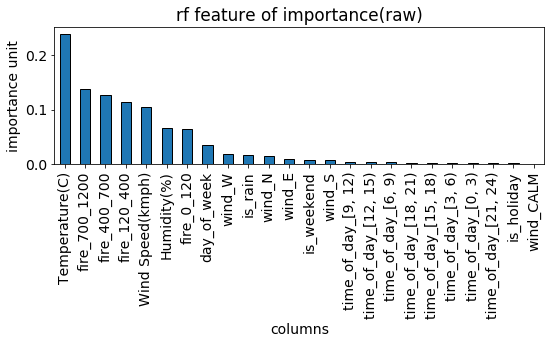

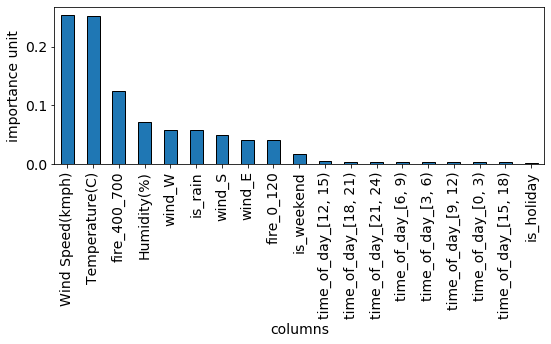

In [205]:
dataset, model, poll_meta = train_city_s1(city= 'Hanoi', pollutant='PM2.5')